In [144]:
%load_ext autoreload
%autoreload 2

from artfinder import load_csv
import pandas as pd
import re
import logging
from typing import cast

logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load data

In [145]:
df = load_csv('database/processed/barcikowski_full.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   publisher               548 non-null    string        
 1   license                 348 non-null    object        
 2   is_referenced_by_count  548 non-null    int64         
 3   link                    486 non-null    object        
 4   authors                 548 non-null    object        
 5   abstract                184 non-null    string        
 6   title                   548 non-null    string        
 7   doi                     548 non-null    string        
 8   type                    548 non-null    string        
 9   journal                 548 non-null    string        
 10  issn                    491 non-null    string        
 11  volume                  480 non-null    string        
 12  issue                   369 non-null    string    

Get some information, which can be usefull for filtering data

In [146]:
# Check types of data entries
df['type'].unique()

<StringArray>
['journal-article', 'proceedings-article']
Length: 2, dtype: string

In [147]:
# Check for duplicates
print(df['doi'].duplicated().sum())
df.drop_duplicates(subset=['doi'], inplace=True)

0


Actually filter articles

In [148]:
# Ablation articles
df_abl = df[df['ablation'] == True]
# correct articles types
df_abl = df_abl[df_abl['type'].isin(['journal-article', 'proceedings-article'])]
# Articles after 1993
df_abl = df_abl[df_abl['publication_date'] > '1993']
# reindex
df_abl.reset_index(drop=True, inplace=True)
#non-ablation articles
df_non_abl = df[df['ablation'] == False]
df_abl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   publisher               292 non-null    string        
 1   license                 197 non-null    object        
 2   is_referenced_by_count  292 non-null    int64         
 3   link                    276 non-null    object        
 4   authors                 292 non-null    object        
 5   abstract                121 non-null    string        
 6   title                   292 non-null    string        
 7   doi                     292 non-null    string        
 8   type                    292 non-null    string        
 9   journal                 292 non-null    string        
 10  issn                    279 non-null    string        
 11  volume                  273 non-null    string        
 12  issue                   213 non-null    string    

Get distribution of publications by year

<Axes: title={'center': 'Publications by Year'}, xlabel='Year', ylabel='Count'>

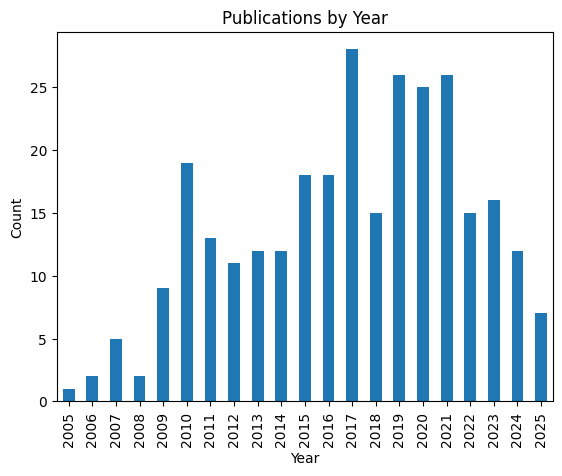

In [149]:
df_cleaned = df_abl.dropna(subset=['publication_date'])
df_cleaned.groupby(df_cleaned['publication_date'].dt.year)['doi'].count().plot.bar(xlabel='Year', ylabel='Count', title='Publications by Year')

Get statistics on publication types

<Axes: title={'center': 'Publications by Type'}, xlabel='Type', ylabel='Count'>

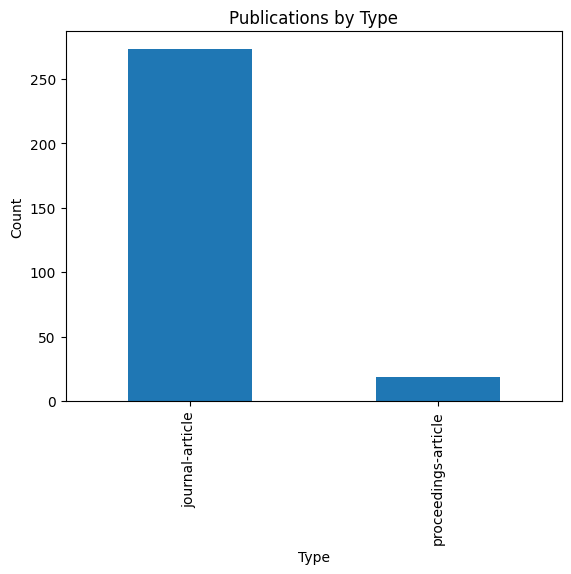

In [150]:
df_abl.groupby('type')['doi'].count().plot.bar(xlabel='Type', ylabel='Count', title='Publications by Type')

Get basic statistic about words from title

In [151]:
display((df_abl[df_abl['ablation']]['title'].map(lambda x: re.findall(r'\b\w{1,3}\b', x)).explode().unique()))
df_abl[df_abl['ablation']]['title'].map(lambda x: re.findall(r'\b\w{4,}\b', x, flags=re.IGNORECASE)).explode().value_counts().head(10)

array(['and', 'in', 'the', 'of', 'by', 'a', 'are', 'we', 'now', 's',
       'jet', 'to', 'sci', '348', '22', '29', 'for', 'oil', nan, 'on',
       'how', 'as', 'ph', 'use', 'bed', 'al', 'ion', 'via', 'air', 'wet',
       'au', 'tio', 'sub', '2', 'gas', 'α', 'up', 'is', 'co2', 'x', 'ray',
       'nir', 'an', '4', 'nm', 'zno', 'one', 'bio', 'at', 'cu', 'net',
       'pre', '45', '3d', 'i', 'non', 'pt', 't', 'pem', 'fe', 'yvo', 'eu',
       'sup', '3', 'g', 'h', 'co', 'no', 'may', 'low', '149', 'ag', 'new',
       '5', 'fed', 'its', 'pd', 'red', 'dna', 'not', 'gfp', 'zn', 'o',
       '164', 'nd', 'b', 'rat', '12', '0', '01', 'vol', 're', 'bcc', 'mg',
       'iro', '10', 'ni', 'γ', 'β', 'y', 'all', 'two', 'pbf', 'lb', 'ito',
       'uv', '11', 'ε', 'top', 'aβ', 'ods', 'oer'], dtype=object)

title
laser            196
nanoparticles    149
ablation          85
gold              64
nanoparticle      62
synthesis         43
pulsed            41
liquids           36
generated         35
during            33
Name: count, dtype: int64

Check how many articles have *nano* in their title and print those, which don't

In [152]:
nps = df_abl[df_abl['title'].str.contains(r'\b\w*nano\w*\b')]
print('Articles with nano:', nps['doi'].count(), 'out of', df_abl['doi'].count())
df_abl[~df_abl['doi'].isin(nps['doi'])][['title', 'abstract']]

Articles with nano: 240 out of 292


,title,abstract
4,quantification of mass-specific laser energy i...,<NA>
8,corrigendum to “quantification of mass-specifi...,<NA>
17,recent progress in laser materials processing ...,<NA>
20,laser synthesis and processing of colloids: fu...,<NA>
22,biocompatible gold submicrometer spheres with ...,this paper highlights a strategy on how totall...
23,opportunities and challenges for laser synthes...,<NA>
31,continuous-flow flat jet setup for uniform pul...,<NA>
41,layered seed-growth of agge football-like micr...,hybrid particles are of great significance in ...
46,how size determines the value of gold: economi...,"gold is one of the most valuable materials, an..."
49,laser ablation in liquids: fundamentals and ap...,<NA>


Check how many articles have *nano* or *laser* in their title and print those, which don't

In [153]:
nps_laser = df_abl[df_abl['title'].str.contains(r'\b\w*nano\w*\b|\b\w*laser\w*\b')]
print('Articles with nano or laser:', nps_laser['doi'].count(), 'out of', df_abl['doi'].count())
df_abl[~df_abl['doi'].isin(nps_laser['doi'])][['title', 'abstract']]

Articles with nano or laser: 285 out of 292


,title,abstract
50,the multivariate interaction between au and ti...,the interaction between a au particle and a de...
60,materials synthesis in a bubble,<NA>
123,comparison of ultrashort pulse ablation of gol...,laser ablation in liquids is a highly interdis...
226,"alumina‐protected, durable and photostable zin...",zinc sulfide has unique and easily modifiable ...
239,bioconjugated silicon quantum dots from one-st...,<NA>
245,impact of preparation method and hydrothermal ...,<NA>
283,golden plasmophores with tunable photoluminesc...,"among various hybrid nanomaterials, the combin..."


It seems like good filter cound contain following restrictions:
* Publication date > 1993
* Publication type *jurnal_article* or *proceedings_article*
* Title contains *nano* or *laser*

However, just checking for *nano* or *laser* in title could be too loose, since it will also include all article about some laser applications and all kinds of nano topics.

Let's try to find some combinations of words, which will be more restrictive, but still describe majority of laser-ablation articles.

First, try to build a strict pattern, which will select articles desctibing laser synthesis of nanoparticles with high probability

In [154]:
#patterns
parts = [
    r'(?=.*laser\w*)(?=.*\w*(gener|synth|prod|manufact|fabric)\w*)(?=.*(nano|colloid|quantum\sdot)\w*|.*\bnps\b)',
    r'(?=.*(nano|particle|cluster)\w*)(?=.*\b\w*(ablat|fragment)\w*)'
]
pattern = r'(' + r'|'.join(parts) + r')'
# exclude patterns
exlude_parts = [
    r'(?!.*nanostructur(ing|ed)\w*)',
]
pattern += r''.join(exlude_parts)
# Check for articles manualy marked to be related to laser ablation with the pattern
df_cleaned[df_cleaned['title'].str.contains(pattern)][['title', 'publication_date', 'doi']]

/tmp/ipykernel_10280/4178239602.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_cleaned[df_cleaned['title'].str.contains(pattern)][['title', 'publication_date', 'doi']]


,title,publication_date,doi
0,trends and current topics in the field of lase...,2011-03-24,10.1021/jp111036a
1,advanced nanoparticle generation and excitatio...,2013-01-01,10.1039/c2cp90132c
2,"process-stable, highly pure nanomaterials by p...",2017-04-21,10.1117/12.2249517
3,a quarter-century of nanoparticle generation b...,2017-03-01,10.1016/j.jcis.2016.12.016
4,quantification of mass-specific laser energy i...,2015-09-01,10.1016/j.apsusc.2014.07.053
...,...,...,...
276,oxide dispersion-strengthened alloys generated...,2018-09-01,10.1016/j.matdes.2018.05.044
279,microstructure formation and mechanical proper...,2021-03-01,10.1016/j.actamat.2020.116566
286,influence of colloidal additivation with surfa...,2023-09-28,10.1002/adem.202301054
289,ultrasonically deposited boron‐doped silicon d...,2025-01-13,10.1002/admi.202400765


Show articles, which were manually marked to be realted to laser ablation, but not matching the strict pattern

In [155]:
df_cleaned[~df_cleaned['title'].str.contains(pattern)][['title', 'publication_date', 'doi']]

/tmp/ipykernel_10280/2180955188.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_cleaned[~df_cleaned['title'].str.contains(pattern)][['title', 'publication_date', 'doi']]


,title,publication_date,doi
6,conjugation efficiency of laser-based bioconju...,2009-10-22,10.1021/jp905962f
10,fully-automatic benchtop machine for the produ...,2021-01-01,10.37904/nanocon.2021.4317
11,colloidal stability of metal nanoparticles in ...,2017-08-08,10.1002/ceat.201600541
16,how citrate ligands affect nanoparticle adsorp...,2012-03-29,10.1021/la204839m
17,recent progress in laser materials processing ...,2020-05-01,10.1016/j.apsusc.2020.145762
...,...,...,...
284,size-selective optical printing of silicon nan...,2019-03-07,10.1021/acsphotonics.8b01619
285,size-selective optical printing of silicon nan...,2020-02-24,10.1117/12.2539265
287,impact of ligands on structural and optical pr...,2021-06-17,10.1021/jacs.1c01799
288,nanocomposite concept for electrochemical <i>i...,2022-07-06,10.1021/jacsau.2c00335


Now let's check for how pattern deals with articles, which were manually marked to be non-related to laser ablative synthesis of nanoparticles

Show articles, which match the strict pattern

In [156]:
df_non_abl[df_non_abl['title'].str.contains(pattern)][['title', 'publication_date', 'doi']]

/tmp/ipykernel_10280/2138274369.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_non_abl[df_non_abl['title'].str.contains(pattern)][['title', 'publication_date', 'doi']]


,title,publication_date,doi
24,laser‐basierte synthese und (elektro‐)chemisch...,2014-08-28,10.1002/cite.201450239
40,laserfragmentierung von anorganischen und orga...,2010-02-22,10.1002/cite.200900099
59,cover picture: opportunities and challenges fo...,2017-05-05,10.1002/cphc.201700410
180,"near-field-enhanced, off-resonant laser sinter...",2014-02-05,10.1007/s00339-014-8270-1
202,powder preparation during ball milling and las...,2022-08-01,10.1016/j.apt.2022.103687
